**OpenBlas may create problems, see below before starting jupyter session**

In [12]:
#!!!! May need to curb OpenBlas threads !!!! (Only once per session)
#export OMP_NUM_THREADS=1 (run directly in command line, not from jupyter notebook)

# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [1]:
from datetime import date
import time
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
# !pip -q install numdifftools 
# !pip -q install parfor
# !pip -q install loompy

     |████████████████████████████████| 99 kB 4.3 MB/s 
     |████████████████████████████████| 189 kB 38.7 MB/s 
     |████████████████████████████████| 41 kB 123 kB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts. The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [4]:
!git clone https://github.com/gennadygorin/seq-cme-technoise

fatal: destination path 'seq-cme-technoise' already exists and is not an empty directory.


In [5]:
!mv seq-cme-technoise/* .
#!rm -r seq-cme-technoise

In [6]:
!mv polyA_ref/* .

In [4]:
# Can add this function later to seq_cme_inference
# Write input txt file

def genRunInput(fname='example_input.txt',dataDir = './',outDir='./',loomName = '',tranName = '',polyaA='15',tInd='0',
                filt='0.01, 0.01, 350, 350, 3, 3',exclude='',attList="[['spliced','unspliced','Gene','Barcode']]",
                seed='42', nGenes='5000', ind='0', gList='', lb='-2, -1.8, -1.8', ub='4.2, 2.5, 2.5',
                restart='1',init='moments',length='True',niter='20',nCu='10',nlambda='11',
                lbSamp='-9, -4',ubSamp='-4, 1.5',suffix='1',creator='tc',ncor='20',override=''):
    '''
    Generate run file for CME inference procedure. 
    Parameters listed in order of appearance in run text file.
    For a dry-run set ind = '-1'.
    '''

    with open(fname, 'w') as f:
        f.write('#Parameter input for CME inference ')
        f.write('\n')
        f.write('dataset_directory : '+dataDir+' : folder with dataset loom files')
        f.write('\n')
        f.write('result_directory : '+outDir+' : where to put the result folder')
        f.write('\n')
        f.write('loom_filenames : '+loomName+' : filenames to integrate')
        f.write('\n')
        f.write('transcriptome_filename : '+tranName+' : transcriptome location')
        f.write('\n')
        f.write('polyA_threshold : '+polyaA+' : minimum polyA count to use for sampling function')
        f.write('\n')
        f.write('transcriptome_ind : '+tInd+' : column of transcriptome file to use (lengths if 0, polyA count if 1)')
        f.write('\n')
        f.write('filter_param : '+filt+' : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S')
        f.write('\n')
        f.write('all_prev_results : '+exclude+': result files with gene names to exclude')
        f.write('\n')
        f.write('attribute_names : '+attList+' : list or list of lists with loom attribute names')
        f.write('\n')
        f.write('gene_sel_seed : '+seed+' : gene selection seed')
        f.write('\n')
        f.write('n_gen : '+nGenes+' : number of genes to select')
        f.write('\n')
        f.write('IND : '+ind+' : loom_filename to analyze')
        f.write('\n')
        f.write('gene_list : '+gList+' : set of result files to import to define gene names')
        f.write('\n')
        f.write('phys_lb : '+lb+' : log10 of lower bound on burst size, splice rate, degradation rate')
        f.write('\n')
        f.write('phys_ub : '+ub+' : upper bound on same')
        f.write('\n')
        f.write('search_restarts : '+restart+' : how many times to run the search for each gene')
        f.write('\n')
        f.write("init_pattern : "+init+" : whether to start the search using method of moments estimate or not; 'random' if not")
        f.write('\n')
        f.write('use_lengths : '+length+' : whether the Poisson sampling for unspliced mRNA should depend on gene length')
        f.write('\n')
        f.write('maxiter : '+niter+' : number of iterations of gradient descent to perform')
        f.write('\n')
        f.write('n_pt1 : '+nCu+' : number of C_u points to evaluate')
        f.write('\n')
        f.write('n_pt2 : '+nlambda+' : number of lambda_s points to evalute')
        f.write('\n')
        f.write('samp_lb : '+lbSamp+' : lower limits of C_u and lambda_s')
        f.write('\n')
        f.write('samp_ub : '+ubSamp+' : upper limits of C_u and lambda_s')
        f.write('\n')
        f.write('ID_suffix : '+suffix+' : folder directory suffix')
        f.write('\n')
        f.write('creator : '+creator+' : directory creator name, can also be used for generic metadata')
        f.write('\n')
        f.write('NCOR : '+ncor+' : number of cores to use')
        f.write('\n')
        f.write("date_override : "+override+": if empty, use today's date from computer. if not, use the given string")




## Inference

Import the processing scripts.

In [5]:
from seq_cme_inference import *
from driver import *
from itertools import combinations
from matplotlib.colors import ListedColormap
import glob
import numpy as np
import pandas as pd

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [8]:
#Make script in future to make these automatically (from user input)
#For dry-run set loom file index (IND) to -1

genRunInput() # Generate example_input.txt 
!cat example_input.txt 

#Parameter input for CME inference 
dataset_directory : ./ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames :  : filenames to integrate
transcriptome_filename :  : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result files to import to define gene names
phys_lb : -2, -1.8, -1.8 : log10 of lower bound on burst size, splice rate, degradation rate
phys_ub : 4

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

Make transcriptome file with gene length and polyA distribution

In [6]:
import re

In [18]:
max_length_repeat = 50
min_length_repeat = 5
hist_bins = np.append(np.arange(min_length_repeat,max_length_repeat+2)-0.5,np.inf)
split_cond = 'C|G|T'
gene_list = []
len_list = []
mean_length = []

with open('/home/tchari/clytiaRef/clytia_all_genes_correct.fa','r') as f:
    c = f.readlines()
    header_lines = [line_num for line_num in range(len(c)) if c[line_num][0] == '>']

    n_genes = len(header_lines)
    n_bins = len(hist_bins)-1
    hist = np.zeros((n_genes,n_bins))
    
    print(n_genes)
#     for jj in range(5):
    for jj in range(n_genes):
        gene_beg = header_lines[jj]
        if jj<len(header_lines)-1:
            gene_end = header_lines[jj+1]
        else:
            gene_end = len(c)
        seq = ''.join([line[0:-1] for line in c[gene_beg+1:gene_end]])
        
        header = c[gene_beg][1:-1]
        header_div = [n for n in range(len(header)) if header[n] == '|']

        gene_start = header[(header_div[0]+1):(header_div[1])]
        gene_end = header[(header_div[1]+1):]
        gene_len = int(gene_end)-int(gene_start)+1
        
        spl_str_len = [len(i) for i in [i for i in re.split(split_cond,seq,flags=re.IGNORECASE) if i]]
        if max(spl_str_len) >= min_length_repeat:
            hist[jj,:] = np.histogram(spl_str_len,hist_bins)[0]

        if np.mod(jj,100) == 0:
            print(str(round(jj/n_genes*100,3))+'%',end='\t')
        
        len_list.append(gene_len)
        gene_name = header[0:(header_div[0])]
        gene_list.append(gene_name)

45872
0.0%	0.218%	0.436%	0.654%	0.872%	1.09%	1.308%	1.526%	1.744%	1.962%	2.18%	2.398%	2.616%	2.834%	3.052%	3.27%	3.488%	3.706%	3.924%	4.142%	4.36%	4.578%	4.796%	5.014%	5.232%	5.45%	5.668%	5.886%	6.104%	6.322%	6.54%	6.758%	6.976%	7.194%	7.412%	7.63%	7.848%	8.066%	8.284%	8.502%	8.72%	8.938%	9.156%	9.374%	9.592%	9.81%	10.028%	10.246%	10.464%	10.682%	10.9%	11.118%	11.336%	11.554%	11.772%	11.99%	12.208%	12.426%	12.644%	12.862%	13.08%	13.298%	13.516%	13.734%	13.952%	14.17%	14.388%	14.606%	14.824%	15.042%	15.26%	15.478%	15.696%	15.914%	16.132%	16.35%	16.568%	16.786%	17.004%	17.222%	17.44%	17.658%	17.876%	18.094%	18.312%	18.53%	18.748%	18.966%	19.184%	19.402%	19.62%	19.838%	20.056%	20.274%	20.492%	20.71%	20.928%	21.146%	21.364%	21.582%	21.8%	22.018%	22.236%	22.454%	22.672%	22.89%	23.108%	23.326%	23.544%	23.762%	23.98%	24.198%	24.416%	24.634%	24.852%	25.07%	25.288%	25.506%	25.724%	25.942%	26.16%	26.378%	26.596%	26.814%	27.032%	27.25%	27.468%	27.686%	27.904%	28.122%	28.34%	28.558%	28.776%	28.994

In [19]:
hist_int = hist.astype('int32')

In [20]:
hist_cum = np.fliplr(np.cumsum(np.fliplr(hist_int),1))

In [21]:
with open('/home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia','w') as file:
    for i in range(n_genes):
        file.write(gene_list[i]+' '+str(len_list[i])+' '+np.array2string(
            hist_cum[i,:],max_line_width=np.inf,separator=' ')[1:-1]+'\n')

In [22]:
!head -10 /home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia

XLOC_000078 3251 12  4  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
XLOC_000001 22202 104  43  23   9   7   6   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
XLOC_000002 46229 226  94  47  23  16  13  13  13  12  12  12  12  12  12  12  12  12  12  12  12  11  11  11  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10
XLOC_000150 1241 6 4 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
XLOC_000151 146 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
XLOC_000079 13316 108  45  16   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
XLO

### **Set global variables**

In [24]:
data_path = '/home/tchari/counts/'

in_fold = 'loom/'
out_fold = 'loom_res/'

transcriptome = '/home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia'

#Dataset-dependent

# Only use neg control samples with >500 cells
control_looms =  ['clytiaGastroderm','clytiaNeural','clytiaEpidermal_Muscle'] 

control_combo_loom = ['clytia_SWall']


proj_fold = 'clytia_stim/'   

override='clytiaRun' #First run only

creator = 'tc'

In [25]:
selGenes = creator+'_'+override+'_selected_genes.csv'
filtGenes = creator+'_'+override+'_filtered_genes.csv'

In [26]:
!mkdir {data_path+proj_fold+out_fold}

### **Conduct gene selection and parameter fitting across Negative Controls**

In [28]:
genRunInput(fname=control_combo_loom[0]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
            outDir=data_path+proj_fold+out_fold,loomName = control_combo_loom[0],
            tranName = transcriptome,override=override)

In [29]:
!cat 'clytia_SWall_input.txt'

#Parameter input for CME inference 
dataset_directory : /home/tchari/counts/clytia_stim/loom/ : folder with dataset loom files
result_directory : /home/tchari/counts/clytia_stim/loom_res/ : where to put the result folder
loom_filenames : clytia_SWall : filenames to integrate
transcriptome_filename : /home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result

['/home/tchari/counts/clytia_stim/loom/clytia_SWall.loom']
Beginning preprocessing routine:
Dataset: /home/tchari/counts/clytia_stim/loom/clytia_SWall.loom
40960 features observed, 40960 match genome annotations. 40960 are unique. 
5251 cells detected.
9979 genes retained as high-expression.
349 genes retained in loom structure based on filter.
Gene set size: 349
-----------
349 genes selected: cannot satisfy query of 5000 genes.
Gene set selected!
Beginning search routine.
40960 features observed, 40960 match genome annotations. 40960 are unique. 
5251 cells detected.
Directory /home/tchari/counts/clytia_stim/loom_res/tc_clytiaRun_clytia_SWall_10x11_349gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 3.1 min.


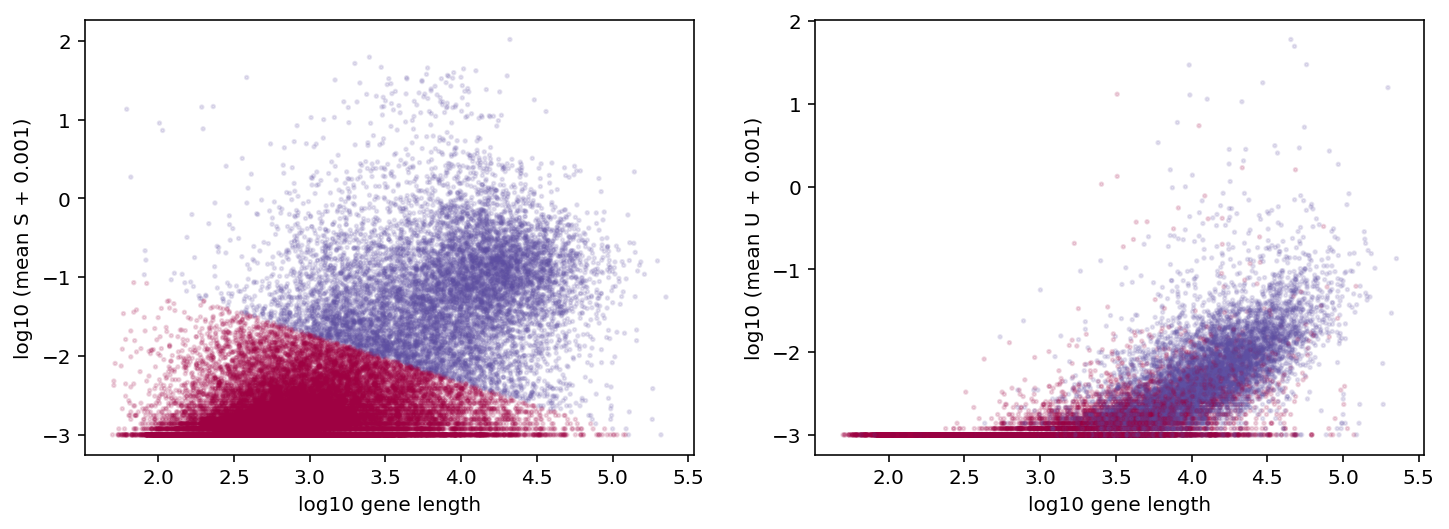

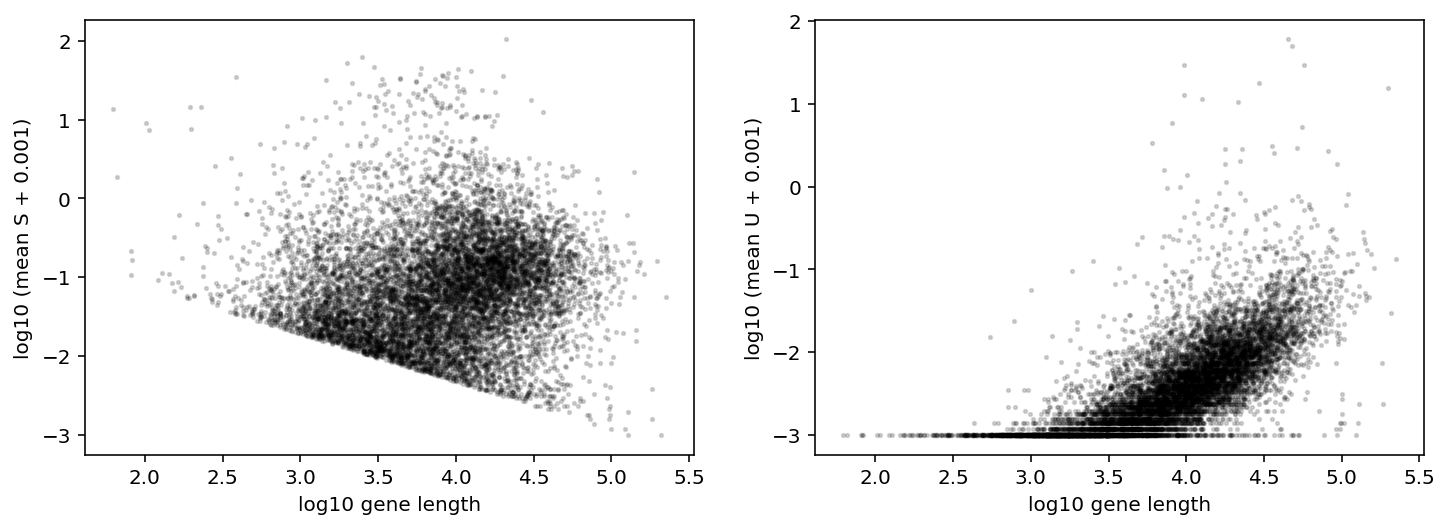

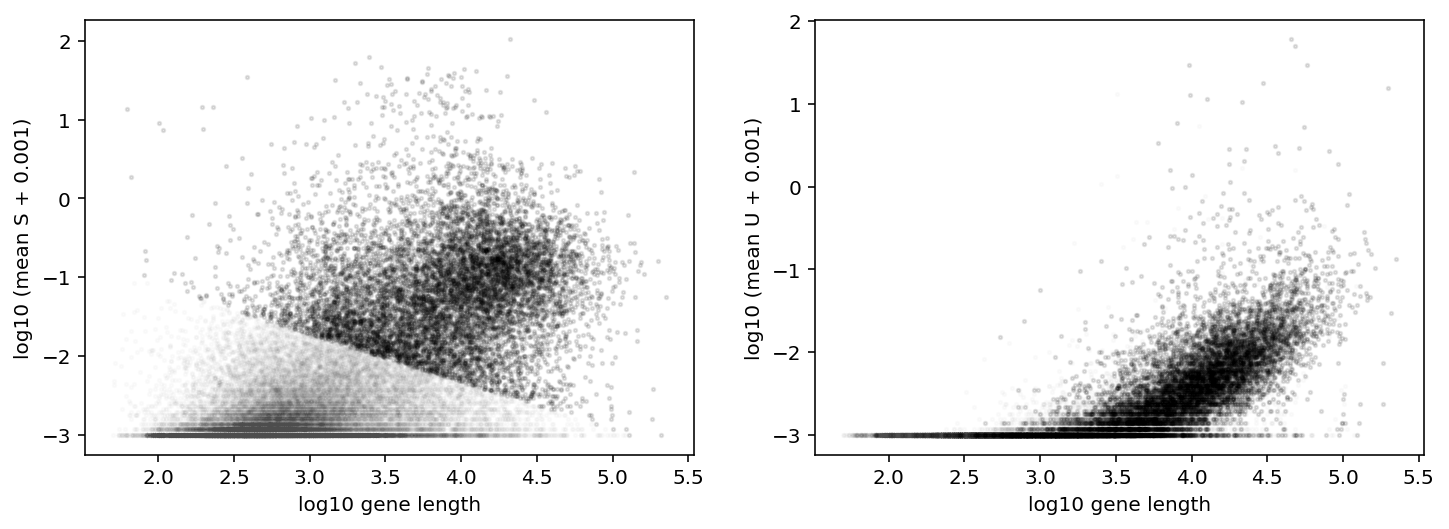

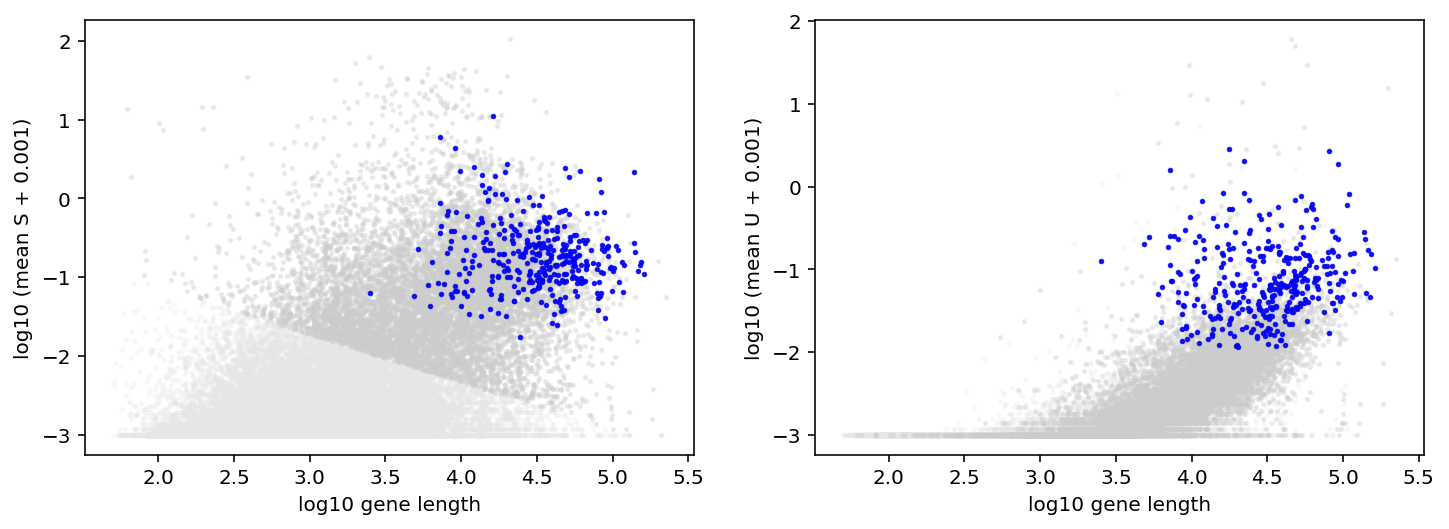

In [30]:
inference_workflow(control_combo_loom[0]+'_input.txt')
#not very many highly expressed gene

['/home/tchari/counts/clytia_stim/loom/clytiaEpidermal_Muscle.loom']
Beginning preprocessing routine:
Dataset: /home/tchari/counts/clytia_stim/loom/clytiaEpidermal_Muscle.loom
45872 features observed, 45872 match genome annotations. 45872 are unique. 
648 cells detected.
13852 genes retained as high-expression.
118 genes retained in loom structure based on filter.
Gene set size: 118
-----------
118 genes selected: cannot satisfy query of 5000 genes.
Gene set selected!
Beginning search routine.
45872 features observed, 45872 match genome annotations. 45872 are unique. 
648 cells detected.
Directory /home/tchari/counts/clytia_stim/loom_res/tc_clytiaRun_clytiaEpidermal_Muscle_10x11_118gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 1.5 min.


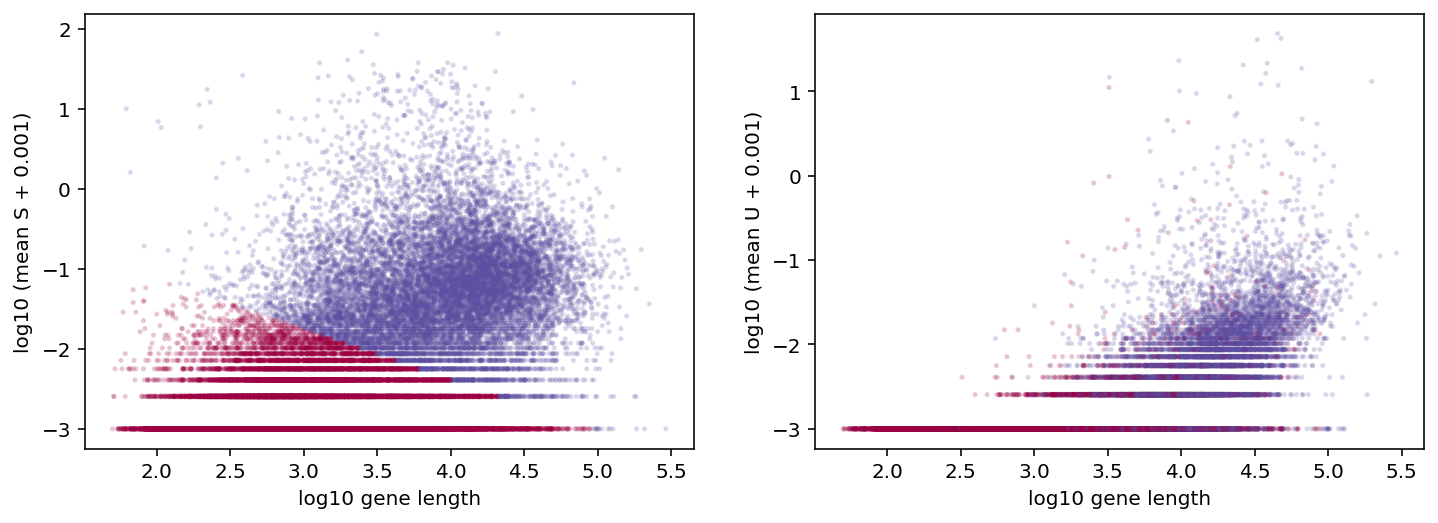

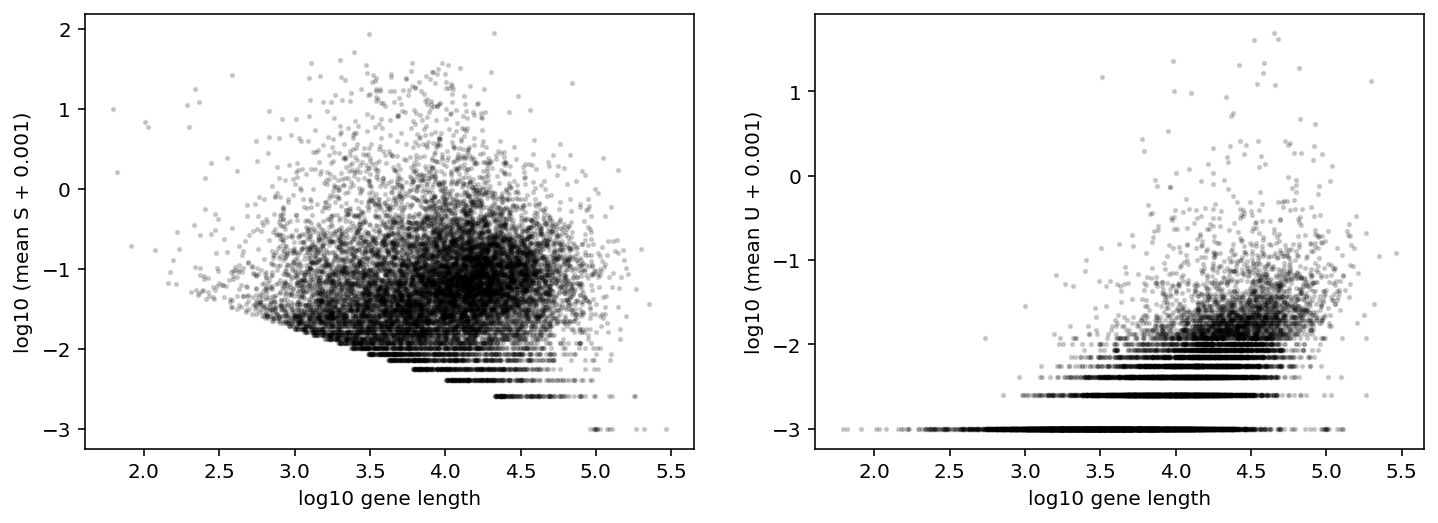

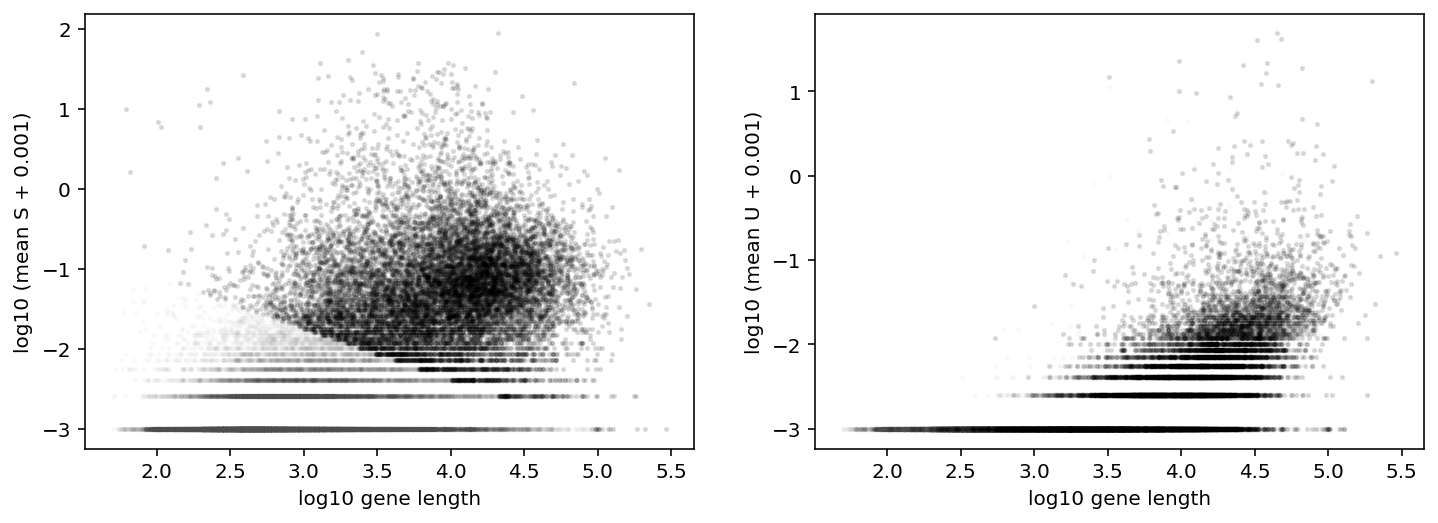

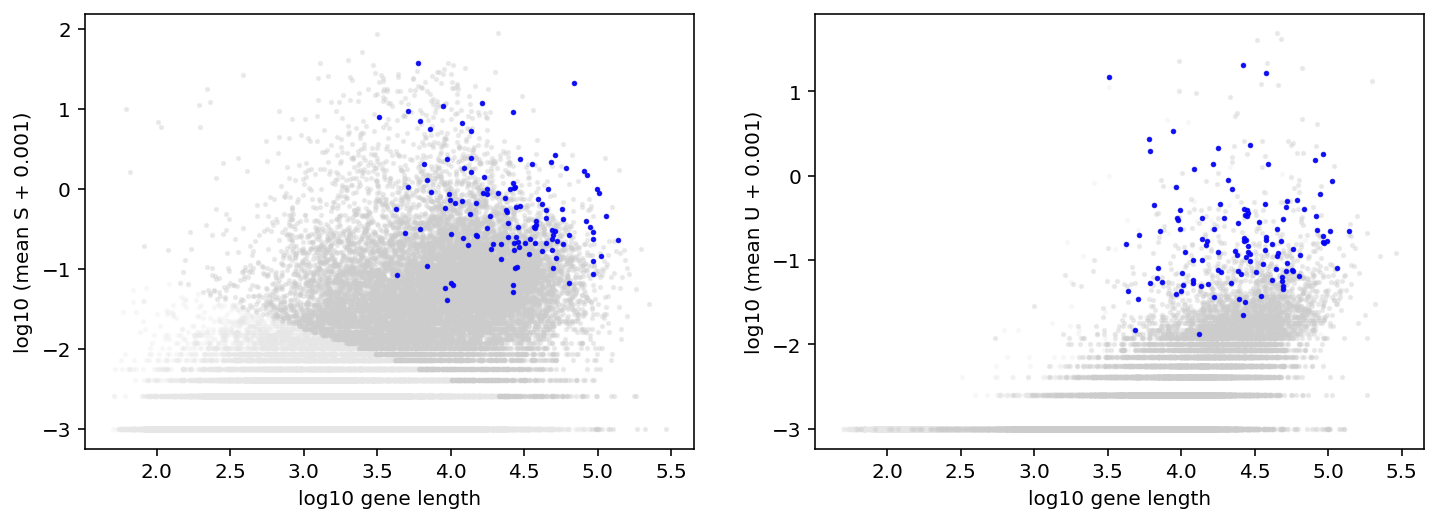

In [35]:
#Set 1x1 grid for sampling parameters
for i in range(2,3):
    genRunInput(fname=control_looms[i]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
                outDir=data_path+proj_fold+out_fold,loomName = control_looms[i],
                tranName = transcriptome,override=override) #gList= selGenes+','+filtGenes
    inference_workflow(control_looms[i]+'_input.txt')
    
#     fname=control_combo_loom[0]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
#             outDir=data_path+proj_fold+out_fold,loomName = control_combo_loom[0],
#             tranName = transcriptome,override=override

['/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl4a_sgNegCtrl3b.loom']
Beginning search routine.
36601 features observed, 36169 match genome annotations. 35727 are unique. 
780 cells detected.
Directory /home/tchari/counts/replogle_crispr/loom_res/tc_run2_crisprsgNegCtrl4a_sgNegCtrl3b_10x11_1595gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 4.6 min.
['/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl8a_sgNegCtrl3b.loom']
Beginning search routine.
36601 features observed, 36169 match genome annotations. 35727 are unique. 
592 cells detected.
Directory /home/tchari/counts/replogle_crispr/loom_res/tc_run2_crisprsgNegCtrl8a_sgNegCtrl3b_10x11_1595gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 4.4 min.
['/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl5a_sgNegCtrl3b.loom']
Beginning search routine.
36601 features observed, 36169

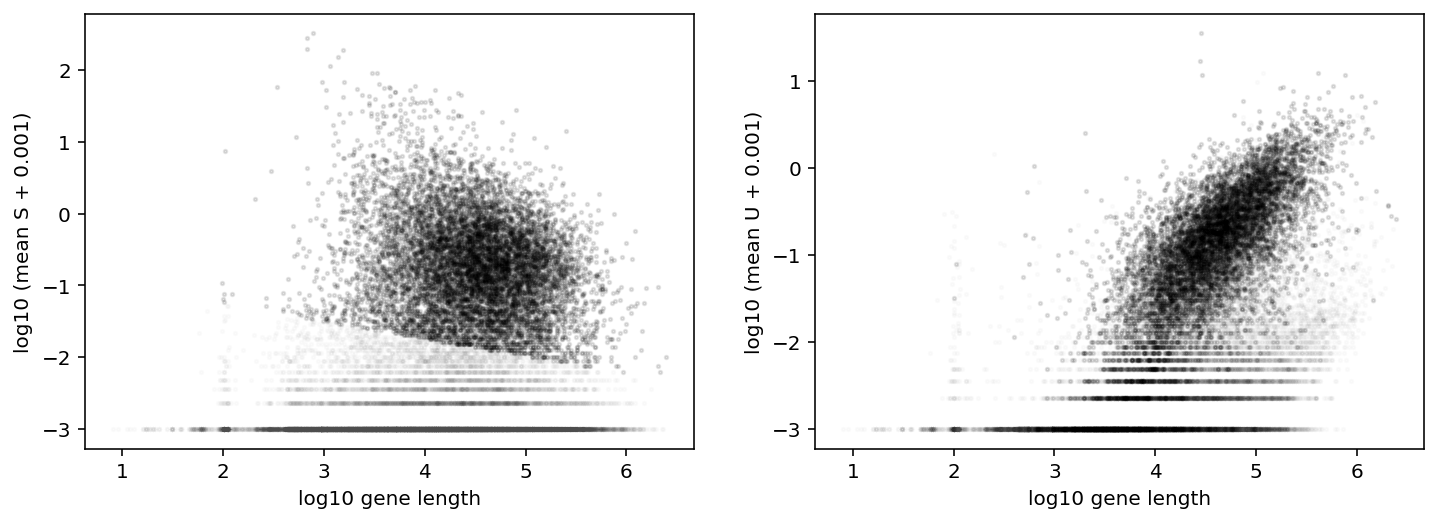

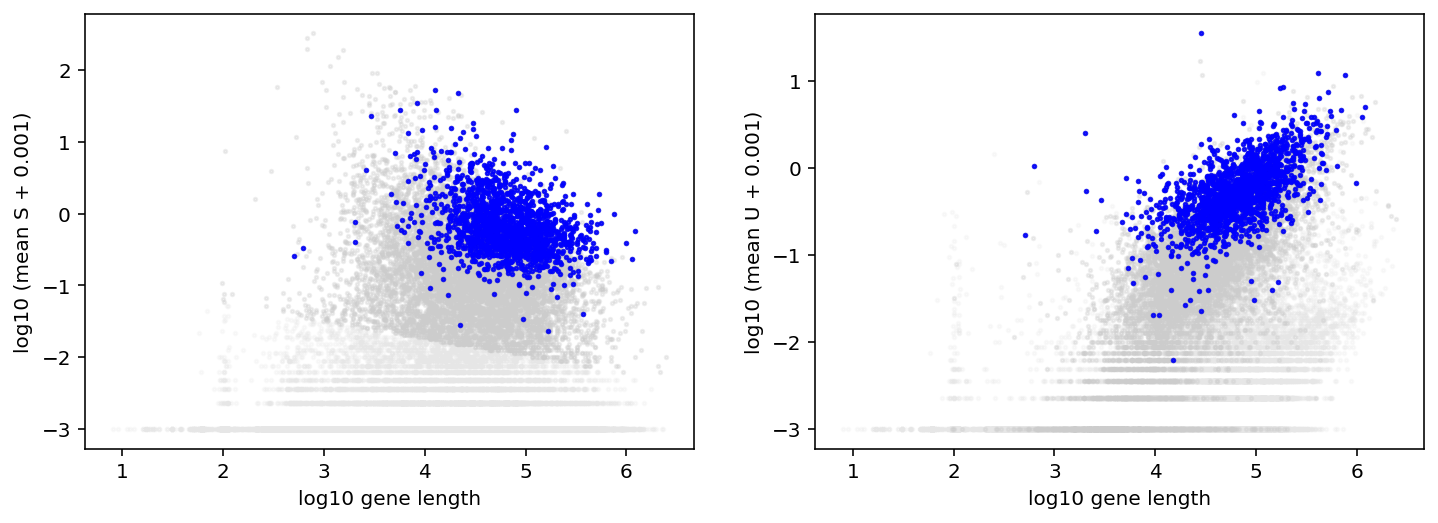

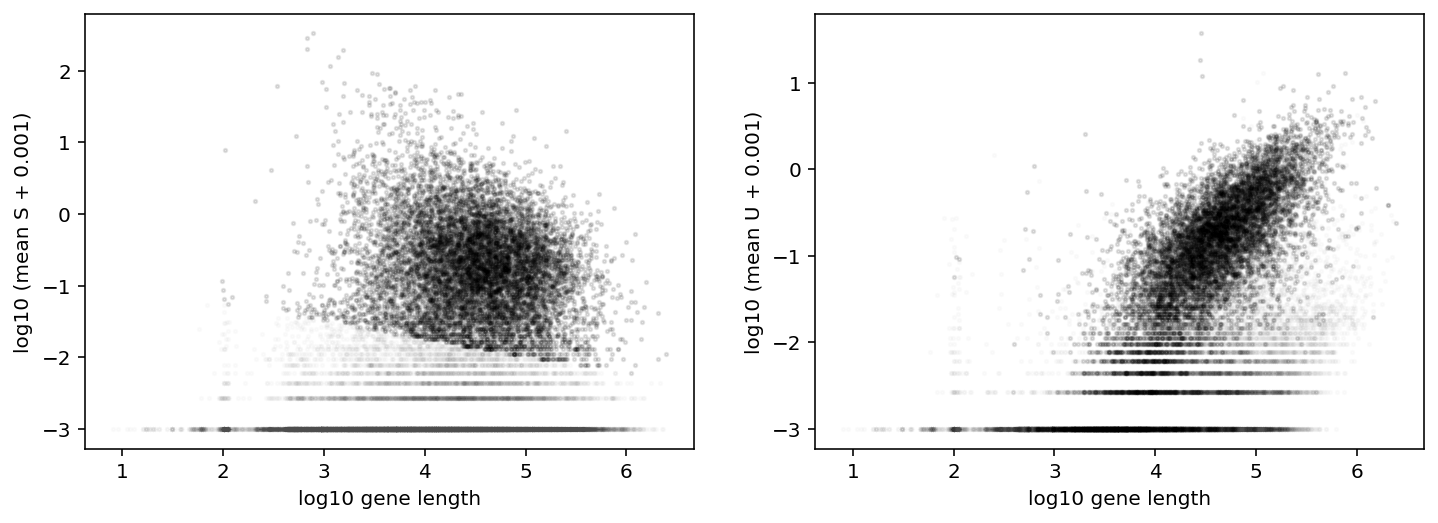

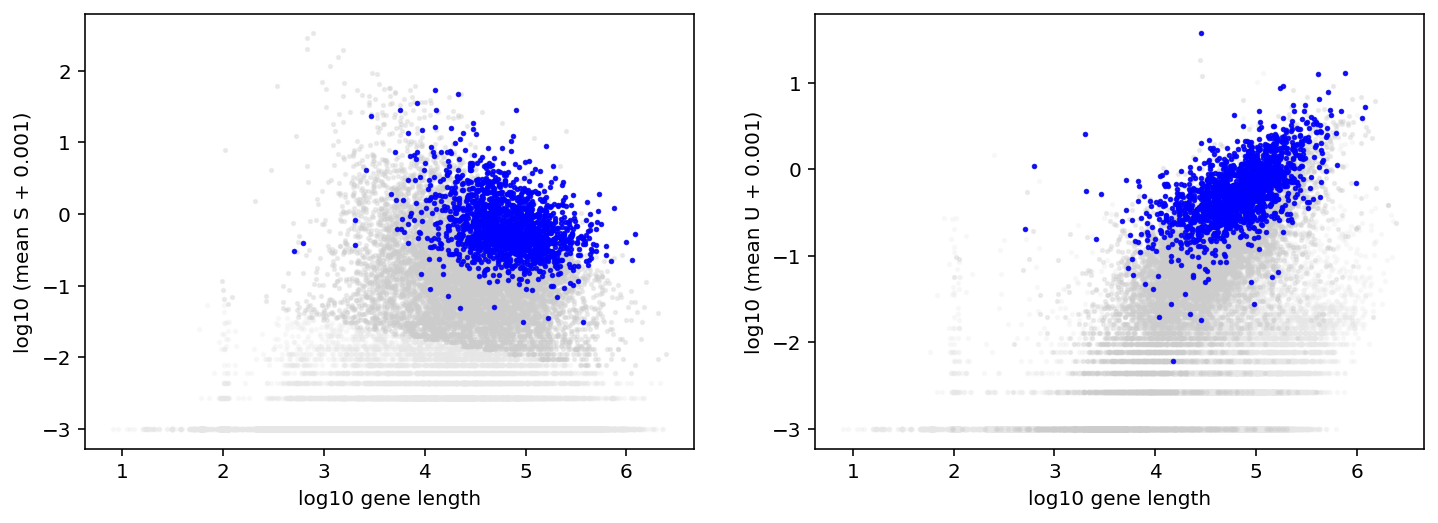

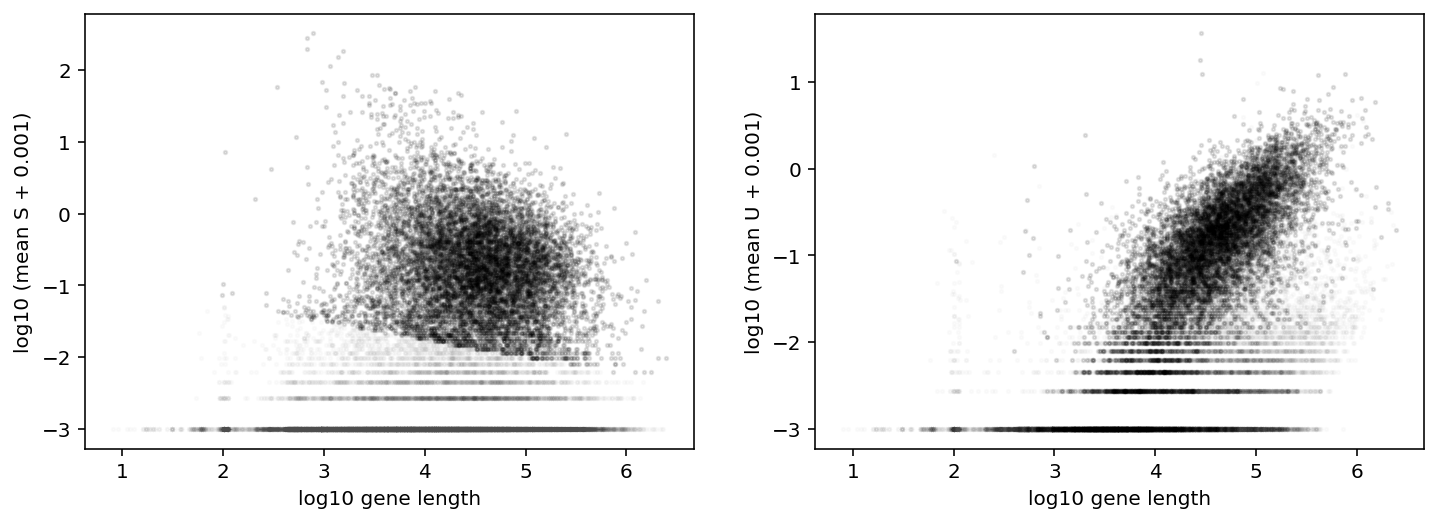

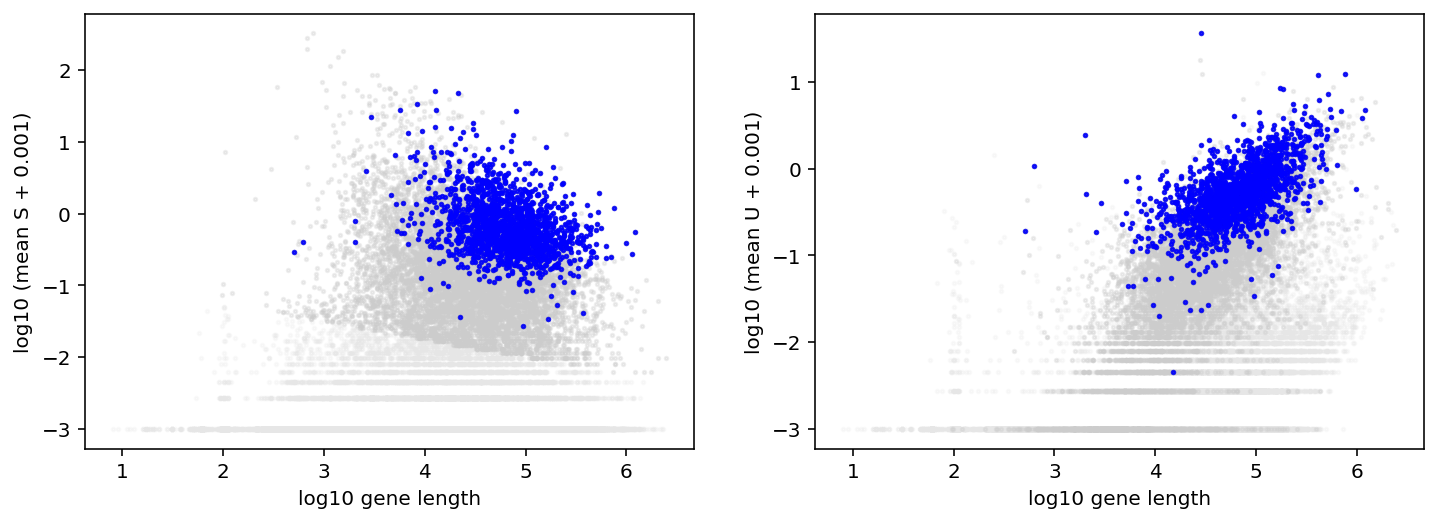

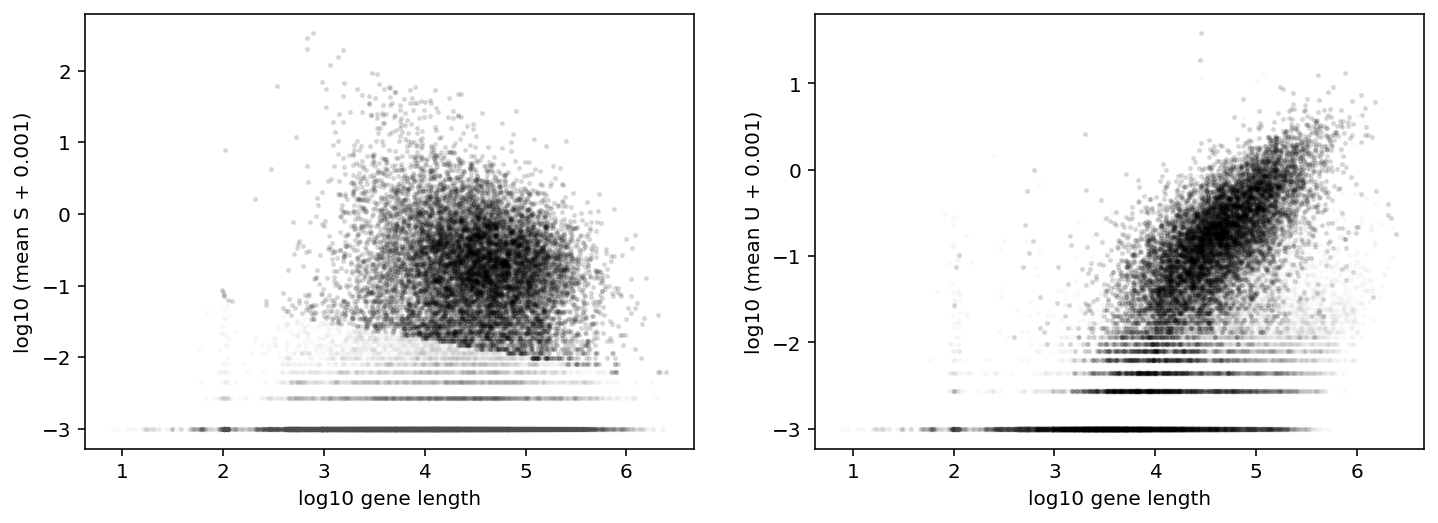

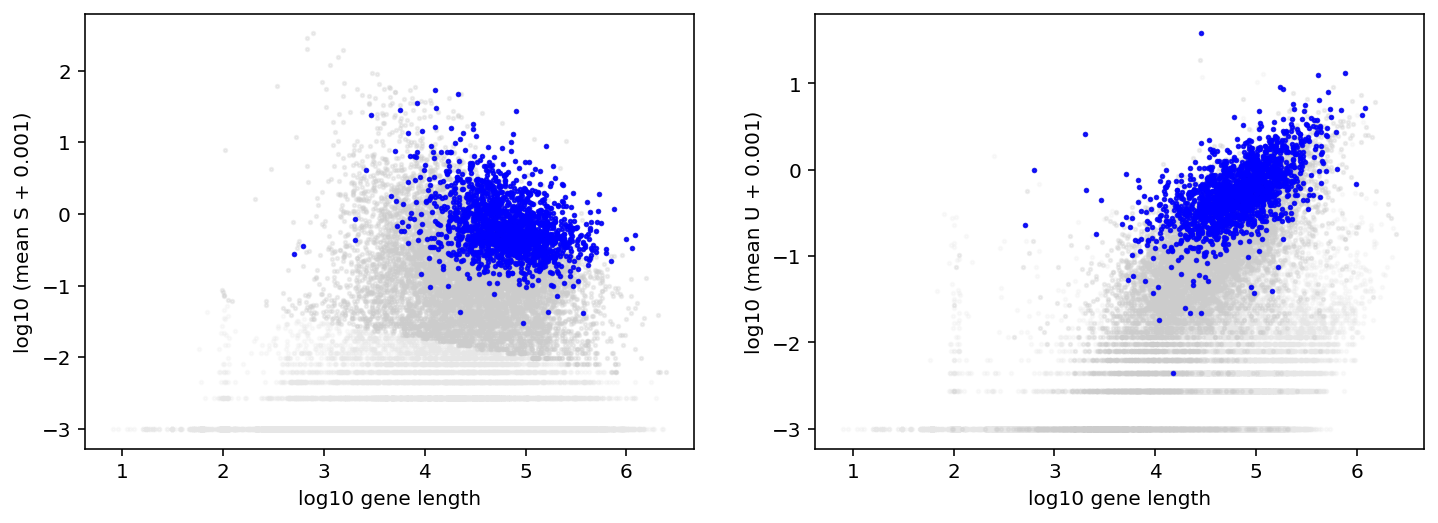

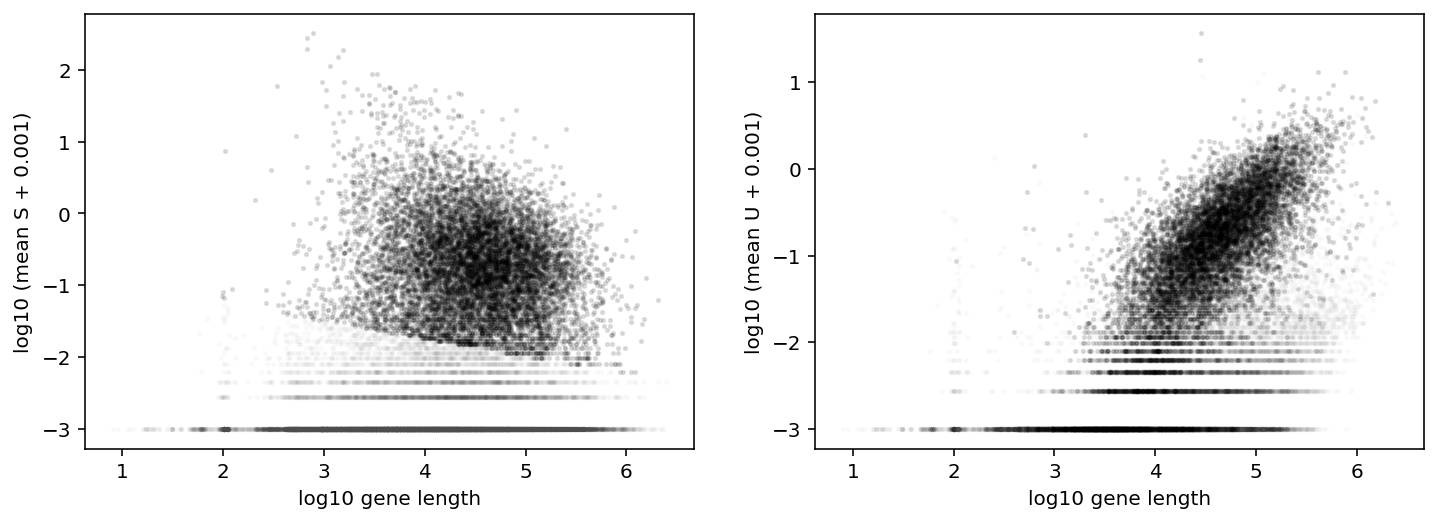

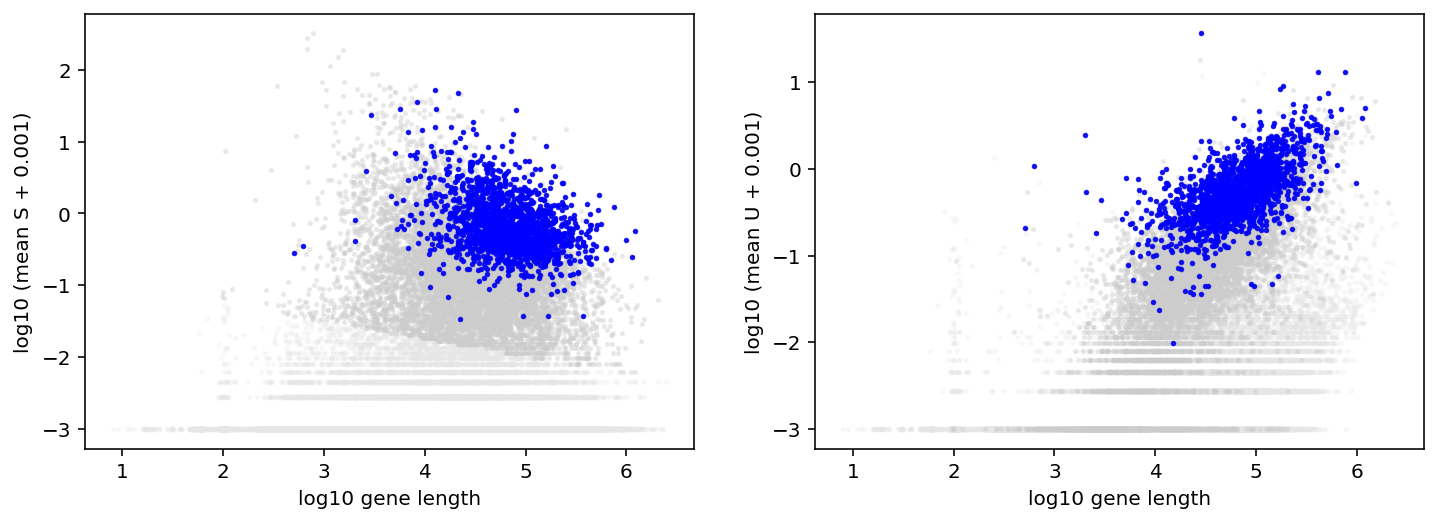

In [13]:
#Set 1x1 grid for sampling parameters
for i in range(1,len(control_looms)):
    genRunInput(fname=control_looms[i]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
                outDir=data_path+proj_fold+out_fold,loomName = control_looms[i],
                tranName = transcriptome,gList= selGenes+','+filtGenes,override=override)
    inference_workflow(control_looms[i]+'_input.txt')

### Control Result Processing

Import the results. This interface can accept multiple inputs: for example, it's possible to use the same grid for searches over several sets of genes and integrate them in downstream analysis. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [14]:
# a e s t h e t i c s

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

In [15]:
outputs = glob.glob(data_path+proj_fold+out_fold+creator+'_'+override+'_*/result.pickle')

In [16]:
def import_precomputed_(filestring):
    with open(filestring,'rb') as f:
        precomp = pickle.load(f)
    return precomp

def check_at_bounds(result_data,phys_params,thr=0.01):
    x = np.any(np.logical_or(
        result_data.search_params.lb_log+thr > phys_params,
        result_data.search_params.ub_log-thr < phys_params) ,1)
    return x


In [17]:
def get_name(fname):
    start = fname.find(data_path+proj_fold+out_fold+creator+'_'+override+'_') + len(data_path+proj_fold+out_fold+creator+'_'+override+'_')
    end = fname.find("_10x11")
    substring = fname[start:end]
    
    return substring

out_names = [get_name(i) for i in outputs]
out_names


['crisprsgNegCtrl1a_sgNegCtrl3b',
 'crisprsgNegCtrl9a_sgNegCtrl3b',
 'crisprsgNegCtrl02093a_sgNegCtrl3b_sgNegCtrl4a_sgNegCtrl3b_sgNegCtrl8a_sgNegCtrl3b_sgNegCtrl5a_sgNegCtrl3b_sgNegCtrl1a_sgNegCtrl3b_sgNegCtrl9a_sgNegCtrl3b',
 'crisprsgNegCtrl02093a_sgNegCtrl3b',
 'crisprsgNegCtrl5a_sgNegCtrl3b',
 'crisprsgNegCtrl4a_sgNegCtrl3b',
 'crisprsgNegCtrl8a_sgNegCtrl3b']

In [18]:
#Read in outputs
results = []
for i in outputs:
     results += [import_datasets([i])]

results[0].raw_S.shape

(1595, 576)

#### **Do chi-squared correction (reject genes with bad fits) and re-evaluate best params**

crisprsgNegCtrl1a_sgNegCtrl3b
crisprsgNegCtrl9a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgNegCtrl3b_sgNegCtrl4a_sgNegCtrl3b_sgNegCtrl8a_sgNegCtrl3b_sgNegCtrl5a_sgNegCtrl3b_sgNegCtrl1a_sgNegCtrl3b_sgNegCtrl9a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgNegCtrl3b
crisprsgNegCtrl5a_sgNegCtrl3b
crisprsgNegCtrl4a_sgNegCtrl3b
crisprsgNegCtrl8a_sgNegCtrl3b


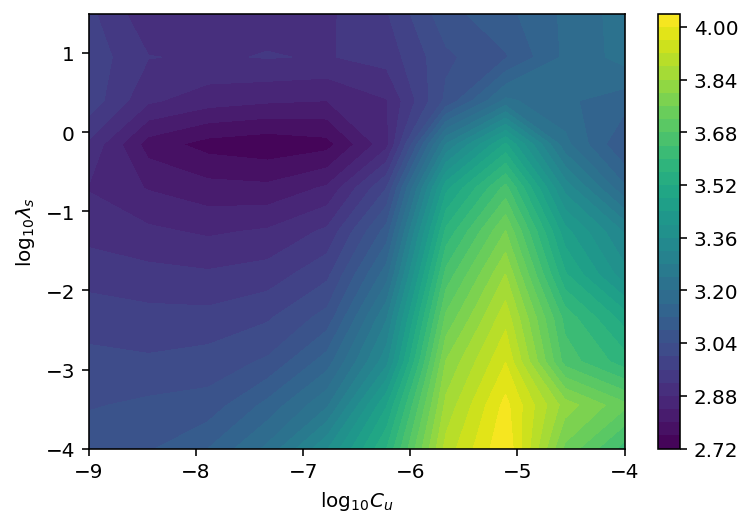

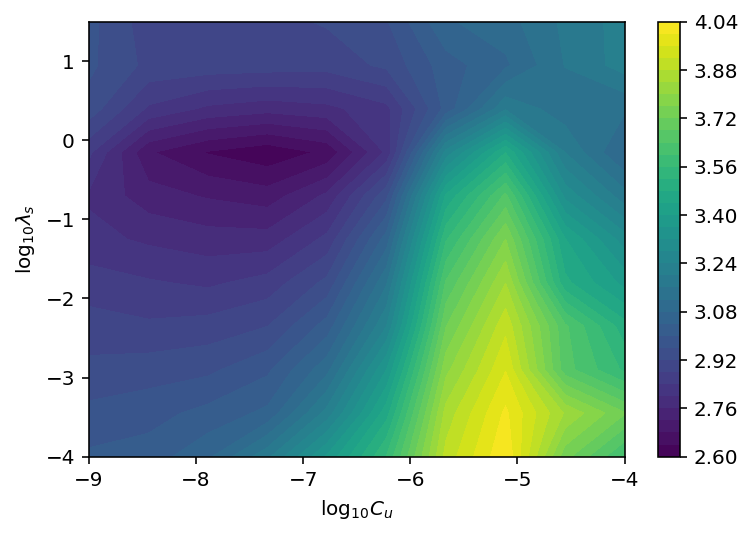

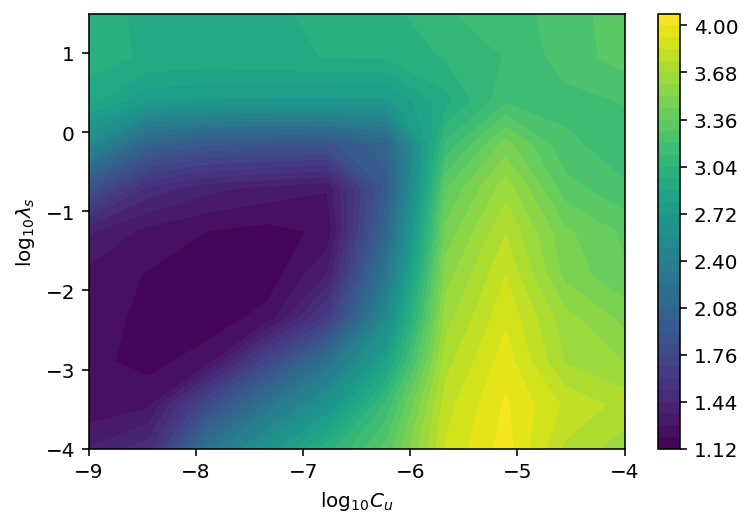

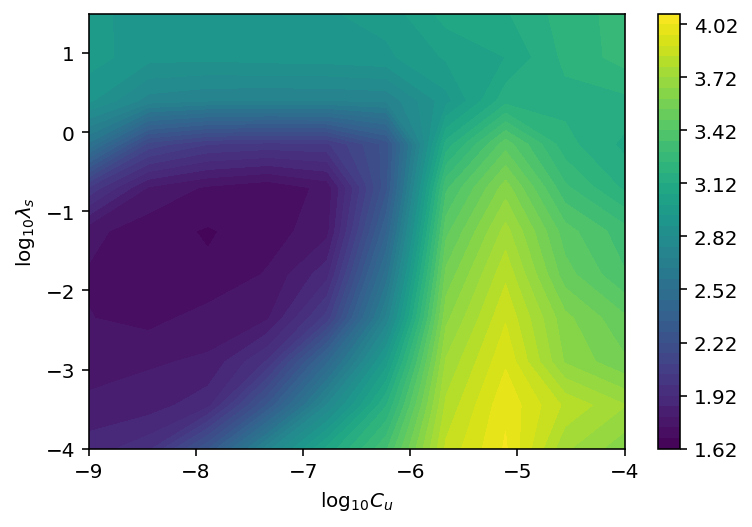

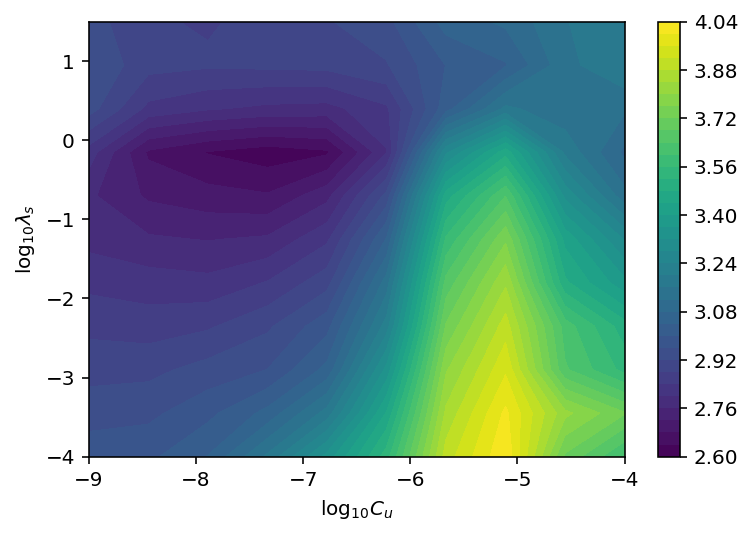

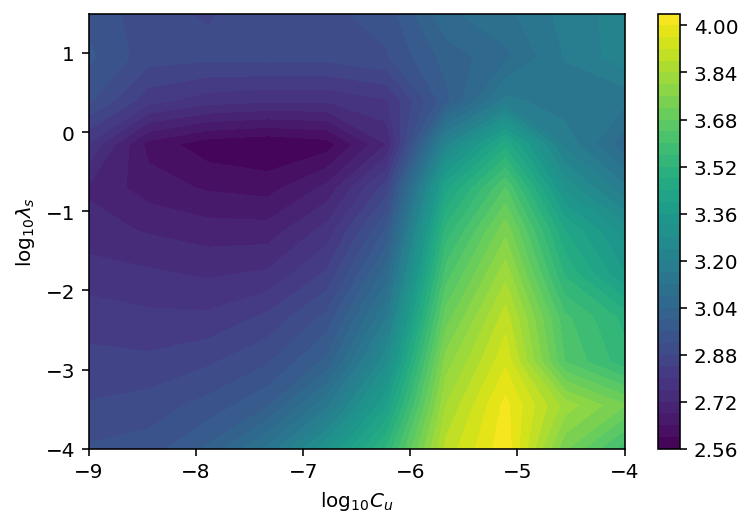

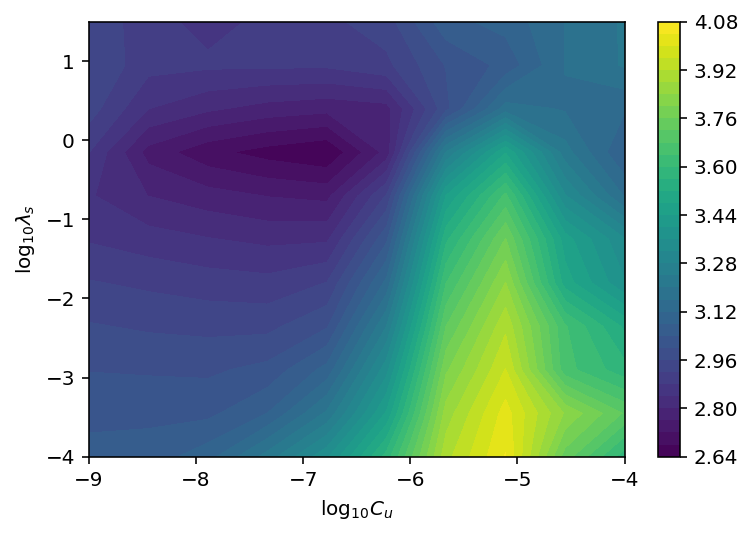

In [19]:
for i in range(0,len(results)):
    print(out_names[i])
    landscape_viz(results[i])

In [20]:
#Run chisq, set rejected genes

#Set some optimal samp params before chisq
for i in range(0,len(results)):
    results[i].find_best_params() 
    print(results[i].best_samp_params)
    
    
for i in range(0,len(results)):
    chisq_gen(results[i])
    compute_sigma(results[i])

(-7.333333333333333, -0.14999999999999947)
(-7.333333333333333, -0.14999999999999947)
(-7.333333333333333, -1.7999999999999998)
(-7.888888888888889, -1.25)
(-7.333333333333333, -0.14999999999999947)
(-7.333333333333333, -0.14999999999999947)
(-6.777777777777778, -0.14999999999999947)


/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 2 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 22 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 77 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 92 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 121 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 153 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 214 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 223 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 229 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 234 gives negative st

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 11 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 12 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 51 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 71 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 92 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 96 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 118 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 121 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 206 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 209 gives negative std

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 254 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 465 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 501 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 504 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 626 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 750 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 975 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 1230 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 2 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 47 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 81 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 87 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 118 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 134 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 198 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 234 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 235 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 256 gives negative st

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 6 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 8 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 134 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 141 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 219 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 224 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 247 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 270 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 285 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 303 gives negative st

/home/tchari/perturbCME/notebooks/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


In [ ]:
#Look at performance of combo control
plot_KL(results[0])
chisq_best_param_correction(results[0],overwrite=True)

In [35]:
# #Get all non-rejected genes across all samples

# filt_genes = set(list(np.where(~results[0].gene_rej)[0]))
# for i in range(1,len(results)):
#     filt_genes = filt_genes.intersection(set(list(np.where(~results[i].gene_rej)[0]))) #Get new filter gene list

In [36]:

# filt_genes = list(filt_genes)
# len(filt_genes)

1142

In [202]:
for i in range(0,len(results)):
    print(out_names[i])
    print(results[i].best_samp_params)

crisprsgNegCtrl1a_sgNegCtrl3b
(-8.444444444444445, -2.9)
crisprsgNegCtrl9a_sgNegCtrl3b
(-8.444444444444445, -2.9)
crisprsgNegCtrl02093a_sgNegCtrl3b
(-7.888888888888889, -1.7999999999999998)
crisprsgNegCtrl5a_sgNegCtrl3b
(-8.444444444444445, -2.9)
crisprsgNegCtrl4a_sgNegCtrl3b
(-7.888888888888889, -1.7999999999999998)
crisprsgNegCtrl8a_sgNegCtrl3b
(-8.444444444444445, -2.9)


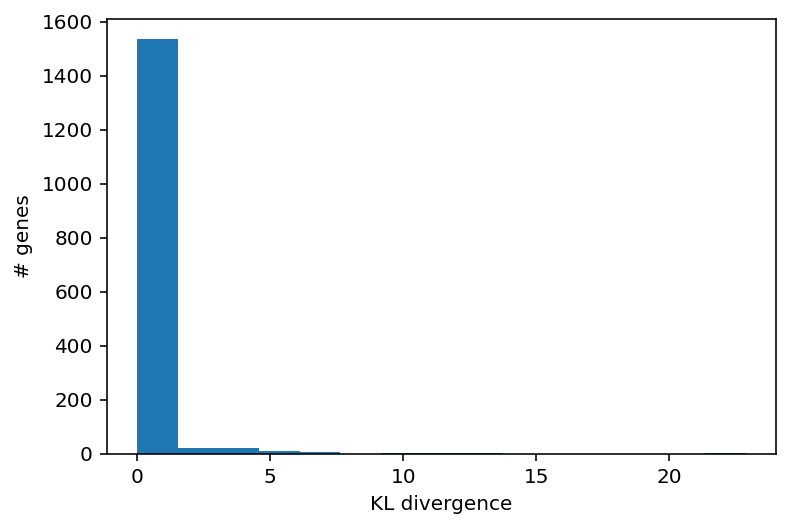

In [143]:
plot_KL(results[0])

(-7.333333333333333, -0.14999999999999947)

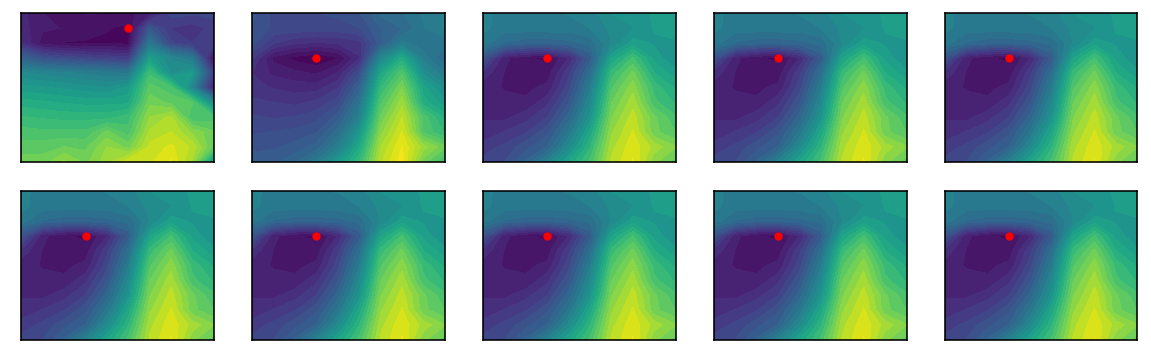

In [129]:
chisq_best_param_correction(results[1],overwrite=True)

In [24]:
c_highlight = col_red
c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=20
cmap = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

In [26]:
combinations_object = combinations(range(0,len(results)), 2)
rep_pairs = list(combinations_object)

(951,)
(951,)
(951,)
(1001,)
(1001,)
(1001,)
(958,)
(958,)
(958,)
(1008,)
(1008,)
(1008,)
(956,)
(956,)
(956,)
(1022,)
(1022,)
(1022,)
(960,)
(960,)
(960,)
(1012,)
(1012,)
(1012,)
(956,)
(956,)
(956,)
(1020,)
(1020,)
(1020,)
(1077,)
(1077,)
(1077,)
(1020,)
(1020,)
(1020,)
(1008,)
(1008,)
(1008,)
(957,)
(957,)
(957,)
(1012,)
(1012,)
(1012,)


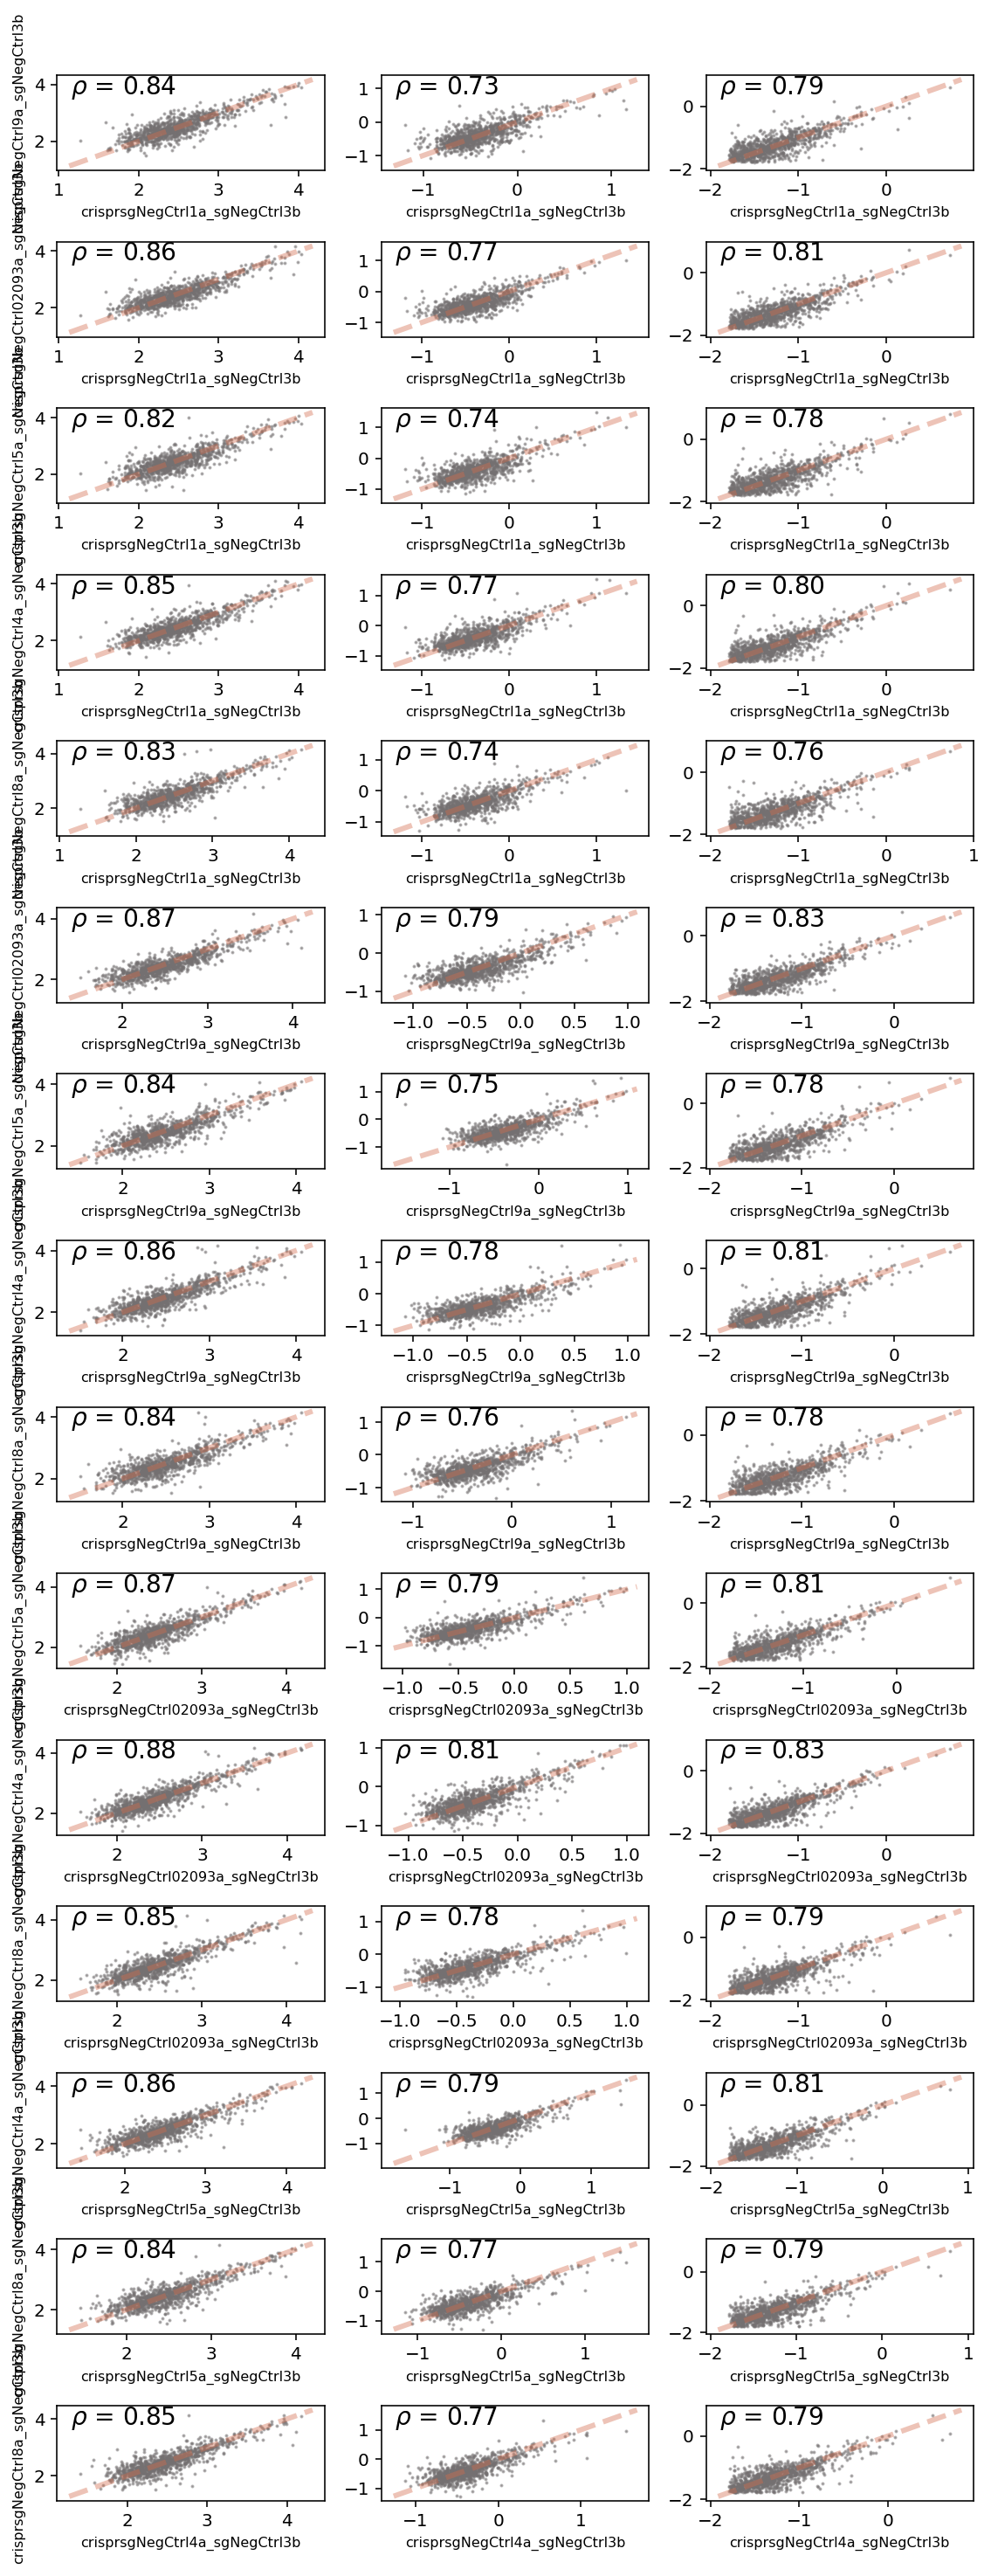

In [57]:
ms,lw,ms_fail,alf,alf_fail = sifig_aesth
fig1, ax1 = plt.subplots(nrows=len(rep_pairs),ncols=3,figsize=(8,20))
nbin=30
for i in range(len(rep_pairs)):
    K = rep_pairs[i]
    #print(looms[K[0]])
    res1 = results[K[0]]#import_precomputed_(results[K[0]])


    #print(looms[K[1]])
    res2 = results[K[1]]#import_precomputed_(results[K[1]])
    #chisq_gen(res2)

    err1 = res1.sigma*2.576
    err2 = res2.sigma*2.576


    for j in range(3):

        filt = ~res1.gene_rej & ~res2.gene_rej \
            & ~check_at_bounds(res1,res1.best_phys_params)\
            & ~check_at_bounds(res2,res2.best_phys_params)
        
#         ax1[i,j].errorbar(res1.best_phys_params[filt,j],
#             res2.best_phys_params[filt,j],
#             err1[filt,j],err2[filt,j],marker=markerstyle,ms=ms,c=col_gold,alpha=alf,linestyle='None',linewidth=lw,zorder=-100)

        ax1[i,j].scatter(res1.best_phys_params[filt,j],
                   res2.best_phys_params[filt,j],color=col_gray,alpha=alf_fail,s=ms_fail)
    
        print(res1.best_phys_params[filt,j].shape)


        fs=14
        sml=8
        rho=np.corrcoef(res1.best_phys_params[filt,j],res2.best_phys_params[filt,j])[0][1]
        xl = ax1[i,j].get_xlim()
        ax1[i,j].plot(xl,xl,'--',color=c_highlight,linewidth=3,alpha=0.4)
        ax1[i,j].set_xlabel(out_names[K[0]],fontsize=sml)

        if j==0:
            ax1[i,j].set_ylabel(out_names[K[1]],fontsize=sml)
        ax1[i,j].text(.05,.8,r'$\rho$ = {:.2f}'.format(rho),fontsize=fs,transform=ax1[i,j].transAxes)

fig1.tight_layout()
fig1.show()

(740,)
(740,)
(740,)
(845,)
(845,)
(845,)
(708,)
(708,)
(708,)
(751,)
(751,)
(751,)
(703,)
(703,)
(703,)
(884,)
(884,)
(884,)
(738,)
(738,)
(738,)
(773,)
(773,)
(773,)
(751,)
(751,)
(751,)
(830,)
(830,)
(830,)
(876,)
(876,)
(876,)
(831,)
(831,)
(831,)
(752,)
(752,)
(752,)
(716,)
(716,)
(716,)
(748,)
(748,)
(748,)


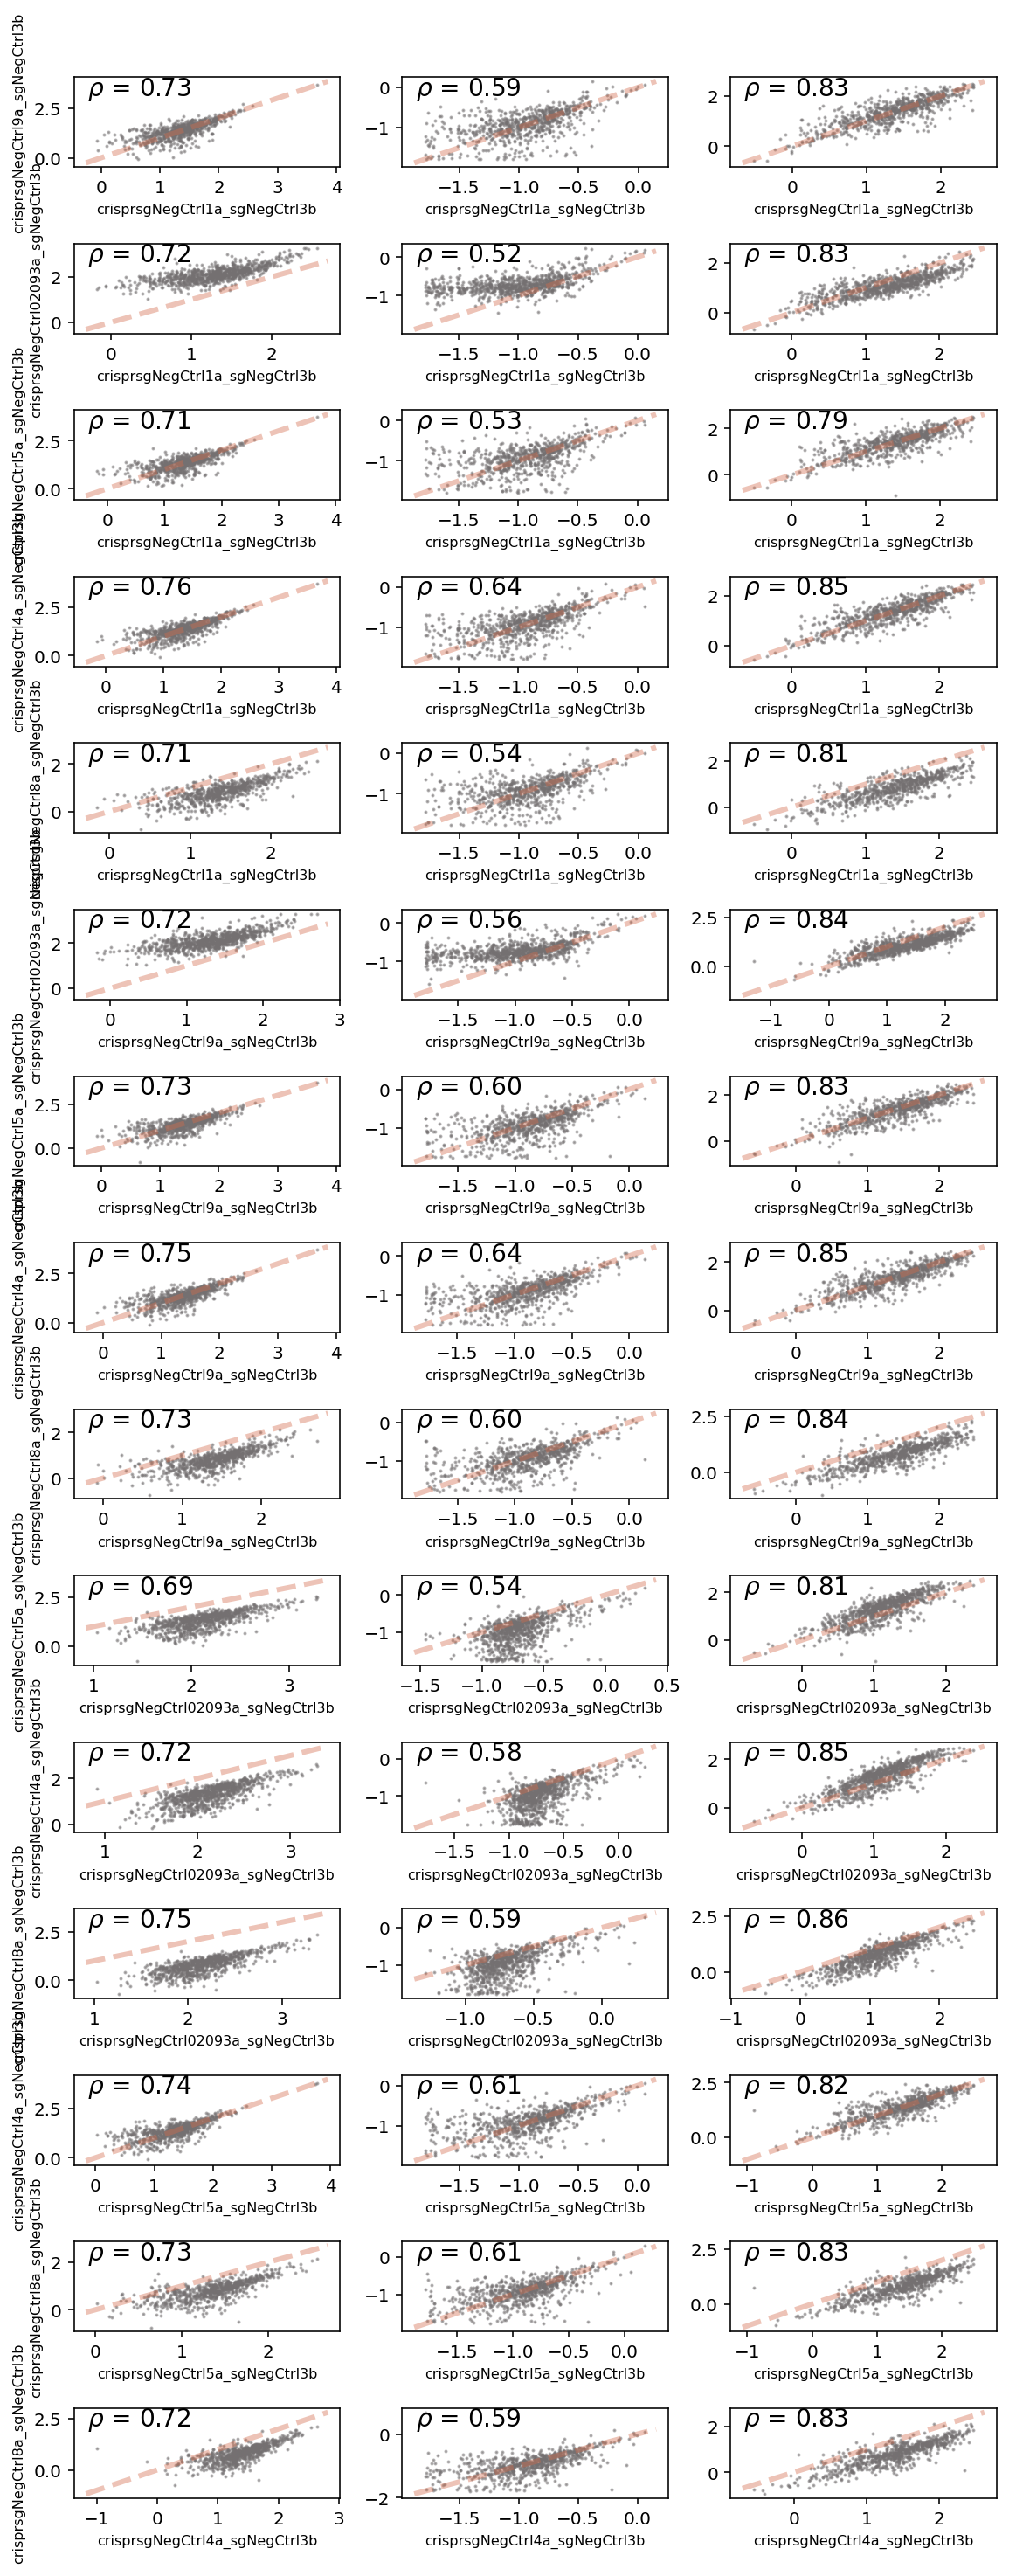

In [44]:
ms,lw,ms_fail,alf,alf_fail = sifig_aesth
fig1, ax1 = plt.subplots(nrows=len(rep_pairs),ncols=3,figsize=(8,20))
nbin=30
for i in range(len(rep_pairs)):
    K = rep_pairs[i]
    #print(looms[K[0]])
    res1 = results[K[0]]#import_precomputed_(results[K[0]])


    #print(looms[K[1]])
    res2 = results[K[1]]#import_precomputed_(results[K[1]])
    #chisq_gen(res2)

    err1 = res1.sigma*2.576
    err2 = res2.sigma*2.576


    for j in range(3):
 
        filt = ~res1.gene_rej & ~res2.gene_rej \
            & ~check_at_bounds(res1,res1.best_phys_params)\
            & ~check_at_bounds(res2,res2.best_phys_params)
        
#         ax1[i,j].errorbar(res1.best_phys_params[filt,j],
#             res2.best_phys_params[filt,j],
#             err1[filt,j],err2[filt,j],marker=markerstyle,ms=ms,c=col_gold,alpha=alf,linestyle='None',linewidth=lw,zorder=-100)

        ax1[i,j].scatter(res1.best_phys_params[filt,j],
                   res2.best_phys_params[filt,j],color=col_gray,alpha=alf_fail,s=ms_fail)
    
        print(res1.best_phys_params[filt,j].shape)


        fs=14
        sml=8
        rho=np.corrcoef(res1.best_phys_params[filt,j],res2.best_phys_params[filt,j])[0][1]
        xl = ax1[i,j].get_xlim()
        ax1[i,j].plot(xl,xl,'--',color=c_highlight,linewidth=3,alpha=0.4)
        ax1[i,j].set_xlabel(out_names[K[0]],fontsize=sml)

        if j==0:
            ax1[i,j].set_ylabel(out_names[K[1]],fontsize=sml)
        ax1[i,j].text(.05,.8,r'$\rho$ = {:.2f}'.format(rho),fontsize=fs,transform=ax1[i,j].transAxes)

fig1.tight_layout()
fig1.show()